# Milestone 2

In order to visualize the notebook, please follow this [link](https://nbviewer.jupyter.org/github/armand33/applied_data_analysis_2017/blob/master/project/notebooks/milestone_2.ipynb#?flush_cache=true) to nbviewer.

The maps are drawn using `folium` and `interact`. In order to run this, you might need to run the bash command :

```
$ jupyter nbextension enable --py --sys-prefix widgetsnbextension 
```

**NB** It is not possible to vizualise the
widget interact on github or on nbviewer. When it is used, we describe how it works but to experience it, the notebook needs to be run.

# Plan of study

Here is the plan of this notebook:

1) Data Analysis : 

    Analyzing all data columns individually:
    - Check the data consistency
    - Get acquainted with it
2) Exploratory Analysis: 

    Here are some axes :
    - Number of actors involved in the events of each country
    - Civilian deaths in each countries
    - Number of events for each country
    - Compare evolution of events type-wise (government or civil or terror)
    - Compare number of deaths in each conflicts



3) Research questions (corresponding to our slightly more nuanced questions of milestone 1):
    1. How has the world evolved in terms of conflicts after the cold war, i.e., during the time span covered in the dataset?
    2. Which countries have undergone the most important crises during these time spans and which of those crises might be interlinked spatially and politically?
    3. Does the coverage of conflicts by media represent the real-world numbers in terms of number of conflicts and fatalities, or is there a bias?

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import json
import branca.colormap as bcm
import numpy as np
import ipywidgets as widgets
from pprint import pprint

from ipywidgets import interact, fixed
from folium.plugins import MarkerCluster

from plots import * # mapping functions in separate Python file helpers.py / plot.py 
                    # because it hinders the reading flow.

# 1. Data Analysis

In [2]:
df = pd.read_csv('../data/ged171.csv')
print(df.shape)

(135181, 42)


We have 135'181 rows, and 42 columns. Needless to say, the sheer amount of columns is overwhelming. At a first glance at the [documentation](http://ucdp.uu.se/downloads/ged/ged171.pdf), the data seems fairly well-documented and an effort for systematic archiving and reliability checking of sources seems to have been made. Nonetheless, it seems chaotic to throw that much data in one huge table.

Let's analyze some groups of features and look for: 
- Meaning
- Possible inconsistencies (if it does not correspond to the documentation)
- Distribution and insight
- Inter-Linkages with other fields

We will do so by looking at subgroups of similar columns such as year, actors, categories of fatalities etc.

#### Year of conflict

Variable Name | Content|Type
---|:---|---
`year`| The year of the event|`integer`
`active_year` |1: if the event belongs to an active conflict/dyad/actoryear<br> 0: otherwise| `Integer`

In [3]:
print('Values of year feature :')
print(df.drop_duplicates('year')['year'].sort_values().values)
print('\nValues of active_year feature')
print(df.drop_duplicates('active_year')['active_year'].sort_values().values)

Values of year feature :
[1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]

Values of active_year feature
[0 1]


##### Consistency: OK

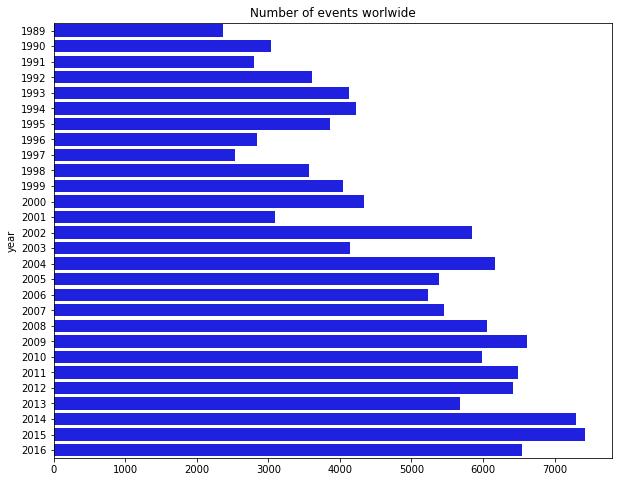

In [4]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(df.groupby('year').count()['id'].values, df.groupby('year').count()['id'].index, ax=ax, color='blue', orient = 'h')
ax.set_title('Number of events worlwide')
plt.show()

There seem to be an increase in the number of events per year since 1989. Whether the graveness or the sum of fatalities in the events also increased remains to be proven.

#### Conflict name

Variable Name | Content|Type
---|:---|---
`conflict_name` | Name of the UCDP conflict to which the event belongs.<br>For non-state conflicts and one-sided violence this is the same as `dyad_name`.|`string(9999)`

In [5]:
df.conflict_name.values[:10]

array(['Yemen (North Yemen):Government',
       'Government of Yemen (North Yemen) - Civilians',
       'Yemen (North Yemen):Government', 'Yemen (North Yemen):Government',
       'Yemen (North Yemen):Government', 'Yemen (North Yemen):Government',
       'Yemen (North Yemen):South Yemen',
       'Yemen (North Yemen):South Yemen',
       'Yemen (North Yemen):South Yemen', 'Yemen (North Yemen):Government'], dtype=object)

This field could probably need a lot of cleanup. Actually it seems pretty useless compared to the fields referring directly to `side_a` and `side_b`. Those fields are way more instructive. See below.

#### `dyad`: Name of the conflict creating the event

Variable Name | Content|Type
---|:---|---
`dyad_new_id` | A unique conflict identification code for each individual `dyad` in the dataset. | `integer`
`dyad_name` | Name of the conflict `dyad` creating the event.<br>_A `dyad` is the pair of two actors engaged in violence (in the case of one-sided violence, the perpetrator of violence and civilians)._ <br> The two sides are separated by an ASCII dash (e.g. Government of Russia - Caucasus Emirate, Taleban - civilians). | `string(9999)`
    `dyad_new_id` | A unique conflict identification code for each individual `dyad` in the dataset. | `integer`
`side_a_new_id` | A unique ID of side A. | `integer`
`gwnoa` |  The Gleditsch and Ward number for Side A if the side is a state. Empty if Side A is not a state. | `string(9999)`
`side_a` | The name of Side A in the `dyad`. In state-based conflicts always a government. In one-sided violence always the perpetrating party. | `string(9999)`
`side_b_new_id` | A unique ID of side B. |`integer`
`gwnob` | The Gleditsch and Ward number for Side B if the side is a state. Empty if Side B is not a state. |`string(9999)`
`side_b` | The name of Side B in the `dyad`. In state-based always the rebel movement or rivalling government. In onesided violence always "civilians". | `string(9999)`

Let's visualize some values of `dyad_new_id` and `dyad_name` to get an idea of what is meant by them:

In [6]:
print("Example of dyad_name: ")
print(df.drop_duplicates('dyad_name')['dyad_name'].sort_values().values[0])
print("\nExample of side_a: ")
print(df.drop_duplicates('side_a')['side_a'].values[0])
print("\nExample of side_b: ")
print(df.drop_duplicates('side_b')['side_b'].values[0])

Example of dyad_name: 
1920 Revolution Brigades - IS

Example of side_a: 
Government of Yemen (North Yemen)

Example of side_b: 
AQAP


Let's verify that `dyad_name` == `sida_a` + ' - ' + `side_b`.

In [7]:
print('Number of inconsistencies between dyad_name and side features : ')
np.sum((df.apply(lambda x:'%s - %s' % (x['side_a'],x['side_b']),axis=1) != df.dyad_name) * 1)

Number of inconsistencies between dyad_name and side features : 


0

##### Consistency: OK

Let's get a list of all the actors involved on `side_a` or `side_b` in all events since 1989.

In [8]:
actors = {}
for i in df.index:
    tmp_id = df.loc[i, 'side_a_new_id']
    if tmp_id in actors.keys():
        actors[tmp_id].add(df.loc[i, 'side_a'])
    if tmp_id not in actors.keys():
        actors[tmp_id] = set()
        actors[tmp_id].add(df.loc[i, 'side_a'])
    tmp_id = df.loc[i, 'side_b_new_id']
    if tmp_id in actors.keys():
        actors[tmp_id].add(df.loc[i, 'side_b'])
    if tmp_id not in actors.keys():
        actors[tmp_id] = set()
        actors[tmp_id].add(df.loc[i, 'side_b'])

`actors` is a dictionary of having as keys `sides_id`s and values the `sides_name`s. 

**Need for cleaning:**
We notice that some sides have more than one actor, such as `High Council of Afghanistan Islamic Emirate, IS`. Both the HCAIE and IS were involved side by side in this event. We want to clean this. In order to do so, we will modify the initial DataFrame `df` fields `side_a`, `side_b`, `side_a_new_id` and `side_b_new_id` and turn those into lists. We now want ids to refer to single actors.

In [9]:
for k in actors.keys():
    n = actors[k].pop()
    n = n.split(',')
    if n[0] == 'Military faction (forces of Honasan': # this is the only case where the split function 
                                                      # gives something inconsistent
        n = [n[0]+n[1]]
    for i in range(len(n)):
        if n[i][0] == ' ':
            n[i] = n[i][1:]
        if n[i][-1] == '':
            n[i] = n[i][:-1]
    actors[k] = n

In [10]:
# this function goes through the dictionary to return the id of the actor.
def find_id(actor):
    for i in actors.keys():
        if actor in actors[i]:
            return i

In [11]:
initial_keys = list(actors.keys())
for k in initial_keys:
    if len(actors[k]) > 1:
        for i in range(len(actors[k])):
            if [actors[k][i]] in actors.values():
                idd = find_id(actors[k][i])
                actors[k][i] = idd
            else:
                # this actor is not in the dictionary yet (it has not been involved on his own in a event)
                # let's create a new id and insert it in the dictionary
                act = actors[k][i]
                actors[k][i] = np.amax(list(actors.keys()))+1 # this is the new id
                actors[np.amax(list(actors.keys()))+1] = [act] # the actor is inserted

Now let's complete the dataframe `df`. `side_a` and `side_b` to be a list of names and `side_a_new_id` and `side_b_new_id` to be a list of ids of actors.

In [12]:
# We need to turn column types ito objects in order to insert lists
df.side_a_new_id = df.side_a_new_id.astype(object)
df.side_b_new_id = df.side_b_new_id.astype(object)

In [13]:
for i in df.index:
    ida = int(df.at[i, 'side_a_new_id'])
    idb = int(df.at[i, 'side_b_new_id'])
    
    if len(actors[ida]) == 1: 
        df.at[i, 'side_a_new_id'] = [ida]
    else:
        df.at[i, 'side_a_new_id'] = [t for t in actors[ida]]
        
    if len(actors[idb]) == 1: 
        df.at[i, 'side_b_new_id'] = [idb]
    else:
        df.at[i, 'side_b_new_id'] = [t for t in actors[idb]]
    
    [actors[k] for k in df.at[i, 'side_a_new_id']]
    df.at[i, 'side_a'] = np.array([actors[k][0] for k in df.at[i, 'side_a_new_id']])
    df.at[i, 'side_b'] = np.array([actors[k][0] for k in df.at[i, 'side_b_new_id']])

Now we can remove the ids that corresponded to multiple actors.

In [14]:
def remove_multiples(d):
    r = dict(d)
    for k in d.keys():
        if len(d[k]) > 1:
            del(r[k])
    return r

actors = remove_multiples(actors)

The following example shows how we have parsed `side_a` and `side_b` to extract the three governments involved in the event on `side_a`.

In [15]:
df.loc[df.index >= 70444, ['conflict_name', 'dyad_name', 'side_a_new_id', 'side_b_new_id', 'side_a', 'side_b']].head(1)

,conflict_name,dyad_name,side_a_new_id,side_b_new_id,side_a,side_b
70444,"Governments of Australia, United Kingdom, Unit...","Government of Australia, Government of United ...","[6740, 28, 3]",[116],"[Government of Australia, Government of United...",[Government of Iraq]


It is now easy to get a list of all the events each actor as been involved in. Thus we could now delete `side_a`, `side_b` and `dyad_name`, since they could all be produced from the actors dictionary, but we'll keep them for now as they might be convenient for quickly plotting data without having to merge tables.

#### Sources
Verify the correctness and properties of sources as done above:

Variable Name | Content|Type
---|:---|---
`number_of_sources` | Number of total sources containing information for an event that were consulted. \* (for data $<$2013, `-1` | `integer`
`source_article` | References to the names, dates and titles of the source material from which information on the event is gathered. A reference to at least one source material is available for ALL EVENTS. This variable is highly streamlined for information collected since 2013, and is less so for older data. For such older data, abbreviations are sometimes used for source agencies. | `text`
`source_office` | The name of the organizations publishing the source materials. \* | `text`
`source_date` | The dates the source materials were published on. \* | `text`
`source_headline` | The titles of the source materials. Note that this variable is only available for data collected for 2013 and 2014, and for recently revised events. For older data, the field is empty. Note that an empty field does NOT mean information on the source is missing; reference to the source material is ALWAYS available in the source_article field, for every event. | `text`
`source_original` | The name or type of person or organization from which the information about the event originates in the original report. e.g. “police”, “Lt. Col. Johnson”, ”eyewitnesses”, “rebel spokesman”. | `string(9999)`


Let's visualize the ditribution of the number of sources 

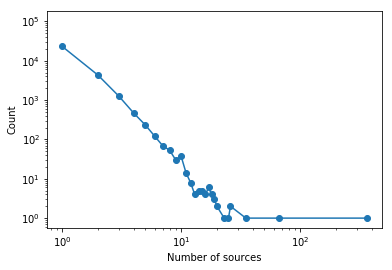

In [16]:
n_sources, count_n_sources = np.unique(df.number_of_sources, return_counts = True)
plt.loglog(n_sources, count_n_sources,marker='o', label=count_n_sources,)
plt.ylabel('Count')
plt.xlabel('Number of sources')
plt.show()

The number of sources for given events varies strongly. For one particular event, there are 365 sources and for two other events, there are 67 and 35 sources, respectively. Let's look at those events

In [17]:
df[df.number_of_sources>=35][['year','dyad_name','number_of_sources']].values

array([[1990, 'Government of Trinidad and Tobago - Jamaat al-Muslimeen',
        363],
       [2016, 'Government of Turkey - IS', 67],
       [2016, 'Government of Turkey - TAK', 35]], dtype=object)

We can see that the most documented conflict was in 1990 between the Government of Trinidad and Tobago and Jamaat al-Muslimeen. Next follow the conflicts involving the Islamic State (`IS`) and conflicts involving the Kurdish population living in Turkey (`TAK`).

Regarding the headlines of the sources, we can also get an impression for instance for the `TAK`
 conflict:

In [18]:
print(df[df.number_of_sources==35]['source_article'].values[0][:100]+"[...]") # cut at 100 characters at most
print('')
print(df[df.number_of_sources==35]['source_headline'].values[0][:100]+"[...]") # cut at 100 characters at most
print('')
print(df[df.number_of_sources==35]['source_original'].values)

"Agence France Presse,2016-02-17,Five dead, 10 wounded in Ankara car bombing: governor";"Agence Fran[...]

Five dead, 10 wounded in Ankara car bombing: governor;Five dead in Ankara car bomb blast targeting m[...]

[ 'Prime Minister Davutoglu; President Tayyip Erdogan; Government spokesman Numan Kurtulmus; Health Minister Mehmet Muezzinoglu']


We can see that this data is in a rather dirty format which doesn't allow easily separating the articles, titles and authors (they are all concatenated with semicolons. This could be improved by exporting them to a separate table `headlines` (some could appear twice for several conflicts, so the headlines need not necessarily be unique). 

**Attention** 
This is related to research question 3. In the documentation of the data set, sources are presented as the sources that allowed the event to be recorded. As the aim of the data set is to record all events and not to record all the sources that recorded all the events, it seems difficult to base our study of the bias of western media only on this data set. We'll get back to this in the third part of this milestone.

#### Geographic Location and formats
Next, we verify the correctness and properties of the different geographic formats used to store the data. The fields containing geographic and political information are the following:

Variable Name | Content|Type
---|:---|---
`where_prec` | The precision with which the coordinates and location assigned to the event reflects the location of the actual event (values 1-7 with decreasing precision, from precise point, to regional supra-country scale) | `integer`
`where_coordinates` | Name of the location to which the event is assigned. Fully standardized and normalized. |`string(9999)`
`adm_1` | Name of the first order (largest) administrative division where the event took place | `string(9999)`
`adm_2` | Name of the second order administrative division where the event took place | `string(9999)`
`latitude` | Latitude (in decimal degrees) | `numeric(9,6)`
`longitude` | Longitude (in decimal degrees) `numeric(9,6)`
`geom_wkt` | An Open Geospatial Consortium textual representation of the location of each individual point. Formatted as `OGC WKT (well known text)` without `SRID`. | `string(9999)`
`priogrid_gid` | The PRIO-grid cell `id (gid)` in which the event took place. Compatibility with PRIO-grid (Tollefsen, 2012) is guaranteed for both PRIO-grid 1 and 2. [...] | `integer`

In [19]:
np.unique(df.where_prec)

array([1, 2, 3, 4, 5, 6, 7])

##### Consistency: OK

In [20]:
print(df.where_coordinates.values[:10])
print('')
print(df.adm_1.values[:10])
print('')
print(df.adm_2.values[:10])

['Şan‘ā’ city' '‘Adan town' 'Abyan governorate' 'Abyan governorate'
 '‘Abīdah valley' 'Abyan governorate' 'Abyan governorate'
 'Abyan governorate' 'Abyan governorate' 'Abyan governorate']

['Amānat al ‘Āşimah governorate' '‘Adan governorate' 'Abyan governorate'
 'Abyan governorate' "Ma'rib governorate" 'Abyan governorate'
 'Abyan governorate' 'Abyan governorate' 'Abyan governorate'
 'Abyan governorate']

[nan nan nan nan 'Ma’rib district' nan nan nan nan nan]


Here, we immediately see there is a formatting problem with some names, maybe due to the encoding. In addition, the name `where_coordinates` is a bit misleading and indicates that there are coordinates, renaming it to `where_name` would make more sense. There are also a few `nan` values, which should be filled with proper `nan` values in Pandas for later recognition.

In [21]:
# rename column
df.rename({'where_coordinates':'where_name'}, inplace=True)

# fill nan values
df.fillna(value = np.NaN, inplace=True)

Lastly, let's check the fields `latitude`, `longitude`, `geom_wkt` and `priogrid_gid`:

In [22]:
df[['latitude','longitude','geom_wkt','priogrid_gid']].head(2)

,latitude,longitude,geom_wkt,priogrid_gid
0,15.354722,44.206667,POINT (44.206667 15.354722),151649
1,12.779444,45.036667,POINT (45.036667 12.779444),148051


All of these fields seem correct, although we might not need all of them according to the use case. The field `geom_wkt` can be reconstructed easily by concatenating the fields `longitude` and `latitude`, `priogrid_gid` will probably not be used, so we delete those two fields.

In [23]:
df.drop(['geom_wkt','priogrid_gid'], axis=1, inplace=True)

#### Countries
The represented countries are:

Variable Name | Content|Type
---|:---|---
`country` | Name of the country in which the event takes place.  | `string(999)`
`country_id` | `Gleditsch` and `Ward number` of the country in which the event takes place. | `integer`
`region` | Region where the event took place. One of following: {Africa, Americas, Asia, Europe, Middle East} | `string(999)`

In [24]:
countries = df.drop_duplicates('country')['country'].sort_values().values
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belgium',
       'Bhutan', 'Bolivia', 'Bosnia-Herzegovina', 'Botswana', 'Brazil',
       'Burkina Faso', 'Burundi', 'Cambodia (Kampuchea)', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'China', 'Colombia',
       'Comoros', 'Congo', 'Croatia', 'DR Congo (Zaire)', 'Djibouti',
       'Ecuador', 'Egypt', 'El Salvador', 'Eritrea', 'Ethiopia', 'France',
       'Georgia', 'Germany', 'Ghana', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Israel', 'Italy', 'Ivory Coast',
       'Jamaica', 'Jordan', 'Kenya', 'Kuwait', 'Kyrgyzstan', 'Laos',
       'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Macedonia, FYR',
       'Madagascar (Malagasy)', 'Malaysia', 'Mali', 'Malta', 'Mauritania',
       'Mexico', 'Moldova', 'Morocco', 'Mozambique', 'Myanmar (Burma)',
       'Namibia', 'Nepal',

Regions:

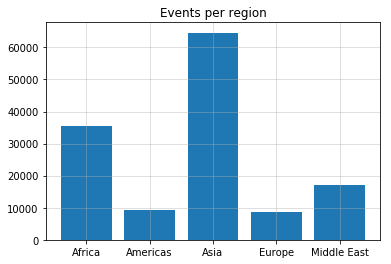

In [25]:
regions, region_counts = np.unique(df.region.values, return_counts = True)
plt.grid(alpha=.5)
plt.bar(regions,region_counts)
plt.title('Events per region')
plt.show()

Interestingly, most conflict records are in Asia and Africa (which doesn't mean most people died in these conflicts)

#### Event confidence, dates

Variable Name | Content|Type
---|:---|---
`event_clarity`| 1 (high): events where the reporting allows the coder to identify the event in full <br> 2 (lower) for events where an aggregation of information was already made by the source material that is impossible to undo in the coding process. Such events are described by the original source only as aggregates\*\* | `integer`

In [26]:
np.unique(df.event_clarity.values, return_counts=True)

(array([1, 2, 3]), array([122442,  12713,     26]))

Differently from what the documentation suggests, there are not only values 1 and 2 for event_clarity but also 3 (although only in 26 cases). It seems unclear what this represent (value 3 is not even described in the extended documentation of the field), but since they are few and greater than 2, it seems reasonable to equate them with category 2 within the logic of the categorical values given (higher for lower confidence). 

In [27]:
df.loc[df['event_clarity'] == 3, 'event_clarity'] = 2

In [28]:
# check that values have been replaced
np.unique(df.event_clarity.values, return_counts=True)

(array([1, 2]), array([122442,  12739]))

#### Dates

Variable Name | Content|Type
---|:---|---
`date_prec` | How precise the information is about the date of an event. 1 (exact date of event is known) to 5 (the date of the event is known only within a rangelonger than one month but not more than one calendar year.) \*\* | `integer`
`date_start` | The earliest possible date when the event has taken place. | `Date YYYY-MMDD`
`date_end` | The last possible date when the event has taken place. | `Date YYYY-MMDD`

In [29]:
np.unique(df.date_prec)

array([1, 2, 3, 4, 5])

The `date_prec` field seems to contain correct values. For the field `date_start` and `date_end`, we first convert them to valid datetime type:

In [30]:
df.date_start = pd.to_datetime(df.date_start,infer_datetime_format=True)
df.date_end = pd.to_datetime(df.date_end,infer_datetime_format=True)

In [31]:
print(df.date_start.min())
print(df.date_end.min())
print(df.date_start.max())
print(df.date_end.max())

1989-01-01 00:00:00
1989-01-01 00:00:00
2016-12-31 00:00:00
2016-12-31 00:00:00


##### Consistency: OK

#### Deaths

Variable Name | Content|Type
---|:---|---
`deaths_a`| The best estimate of deaths sustained by side a. Always 0 for one-sided violence events. | `integer`
`deaths_b` | The best estimate of deaths sustained by side b. Always 0 for one-sided violence events. | `integer`
`deaths_civilians` | The best estimate of dead civilians in the event. For non-state or state-based events, this is the number of collateral damage resulting in fighting between side a and side b. For one-sided violence, it is the number of civilians killed by side a. | `integer`
`deaths_unknown` | The best estimate of deaths of persons of unknown status. | `integer`
`best_est` | The best (most likely) estimate of total fatalities resulting from an event. It is always the sum of `deaths_a`, `deaths_b`, `deaths_civilians` and `deaths_unknown`. | `integer`
`high_est` | The highest reliable estimate of total fatalities  | `integer`
`low_est` | The lowest reliable estimate of total fatalities | `integer`


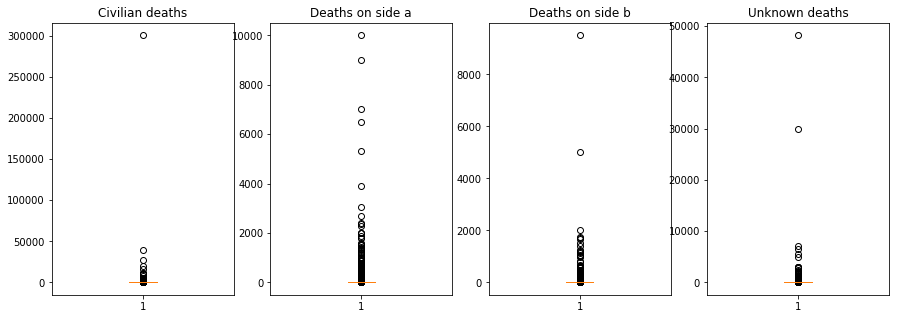

In [32]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(15,5)
ax[0].boxplot(df.deaths_civilians)
ax[0].set_title('Civilian deaths')

ax[1].boxplot(df.deaths_a.values)
ax[1].set_title('Deaths on side a')

ax[2].boxplot(df.deaths_b.values)
ax[2].set_title('Deaths on side b')

ax[3].boxplot(df.deaths_unknown.values)
ax[3].set_title('Unknown deaths')

plt.show()

In [33]:
print('Mean:') # not median, since it is mostly 0, even with the conditions below
print(df[((df.deaths_a)>0 & (df.deaths_b > 0)) & ((df.deaths_civilians)>0 & (df.deaths_unknown > 0))]
      [['deaths_a','deaths_b','deaths_civilians','deaths_unknown']].mean())
print('\nStandard deviation:')
print(df[((df.deaths_a)>0 & (df.deaths_b > 0)) & ((df.deaths_civilians)>0 & (df.deaths_unknown > 0))]
      [['deaths_a','deaths_b','deaths_civilians','deaths_unknown']].std())
print('\nSum:')
print(df[((df.deaths_a)>0 & (df.deaths_b > 0)) & ((df.deaths_civilians)>0 & (df.deaths_unknown > 0))]
      [['deaths_a','deaths_b','deaths_civilians','deaths_unknown']].sum())


Mean:
deaths_a            5.674465
deaths_b            4.275735
deaths_civilians    4.975936
deaths_unknown      1.002005
dtype: float64

Standard deviation:
deaths_a            21.301194
deaths_b            26.478996
deaths_civilians    16.323955
deaths_unknown       8.654094
dtype: float64

Sum:
deaths_a            16978
deaths_b            12793
deaths_civilians    14888
deaths_unknown       2998
dtype: int64


It seems interesting to note that on avarage and overall (summed up) more parties in party A die than in party B (could this be a data bias?). However, there are many outliers. Also, in the total dataset, about as many people die as there are fatalities in one of the parties (14888 is between 12793 and 16978).

Let's visualize the best estimation of deaths each year.

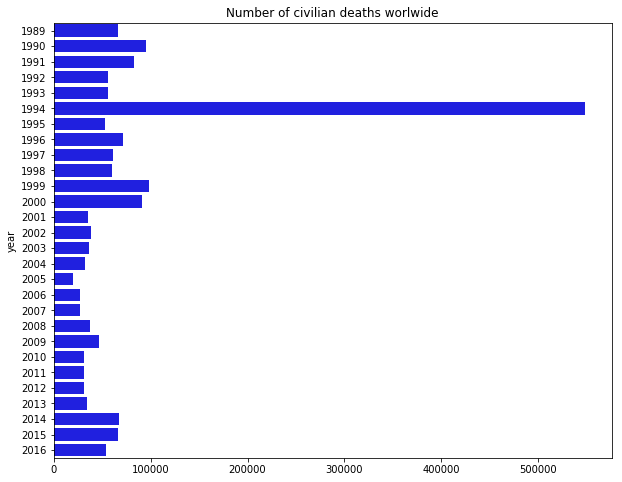

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(df.groupby('year').sum()['best'].values, df.groupby('year').sum()['best'].index, ax=ax, color='blue', orient = 'h')
ax.set_title('Number of civilian deaths worlwide')
plt.show()

- Rwanda has been the most devasted country in count of civilian deaths (500k in 1994)
- Then comes the Democratic Republic of Congo (Zaire) with 30k in 1996

Let's note that 1990, 1999 and 2000 seem to have been the most deadly years (excluding the Rwandan genocide). Let's find out what happened during those years later in the notebook.

# 2. Exploratory Analysis:

Next up, we want to explore the data further combining some of the features described above:

- Number of actors involved in the events of each country
- Civilian deaths in each country
- Number of events for each country
- Compare evolution of events type-wise (government or civil or terror)
- Compare number of deaths in each conflict

#### Map Visualization Tools

In the attached file `plots.py` there are functions in order to visualize data to the scale of a country for each year. We use a slider (from the widget interact) to select the year we want to visualize. This only works when the notebook is being executed and according to this [link](https://github.com/jupyter-widgets/ipywidgets/issues/1085) it will not be possible to visualize it in a viewer until the next version of ipywidgets.

Import some json data for the entire world:

In [35]:
topo_path = '../data/topojson-master/world-countries-sans-antarctica.json'
topo_data = json.load(open(topo_path))

Get all centroids of the countries in order to add markers when needed.

In [36]:
centro = pd.read_csv('../data/country_centroids_primary.csv', sep=('\t')).loc[:, ['LAT', 'LONG', 'SHORT_NAME']]
centro.columns = ['lat', 'long', 'name']

### Actors involved in each country

In [37]:
d = dict()
for i in countries:
    s = set()
    tmp = df.loc[df.country == i]
    s = s.union(set(np.concatenate(tmp.loc[:,'side_a'].values)))
    s = s.union(set(np.concatenate(tmp.loc[:,'side_a'].values)))
    d[i] = s

In [38]:
x = list(d.keys())
y = [i for i in map(lambda x: len(x), d.values())]
y, x = zip(*sorted(zip(y, x), reverse=True))

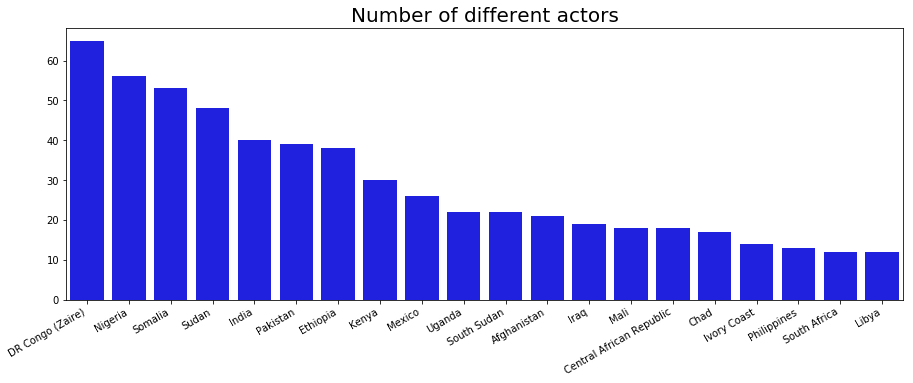

In [39]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.barplot(x=np.asarray(x[0:20]), y=np.asarray(y[0:20]), ax=ax, color='blue')
ax.set_xticklabels(np.asarray(x[0:20]), rotation=30, horizontalalignment='right', fontsize=10)
ax.set_title('Number of different actors', fontsize=20)
plt.show()

### Civilian deaths in each country

In [40]:
year_country = df.groupby(['country', 'year'])['deaths_civilians'].sum()
tmp = pd.DataFrame(year_country)
civilian_deaths = pd.DataFrame(index=countries, columns=df.drop_duplicates('year')['year'].sort_values().values)
civilian_deaths.fillna(value=0, inplace=True)

for i in tmp.index:
    civilian_deaths.loc[i[0], i[1]] = tmp.loc[i].values

civilian_deaths.head()

,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Afghanistan,303,101,49,1695,637,120,185,483,353,6341,...,669,763,1099,1178,1024,908,930,876,899,1076
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Algeria,0,0,1,5,37,30,15,9,361,143,...,31,58,48,26,17,23,27,1,1,0
Angola,297,191,212,32,761,304,56,1,45,214,...,1,1,0,6,0,0,0,0,0,1
Argentina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


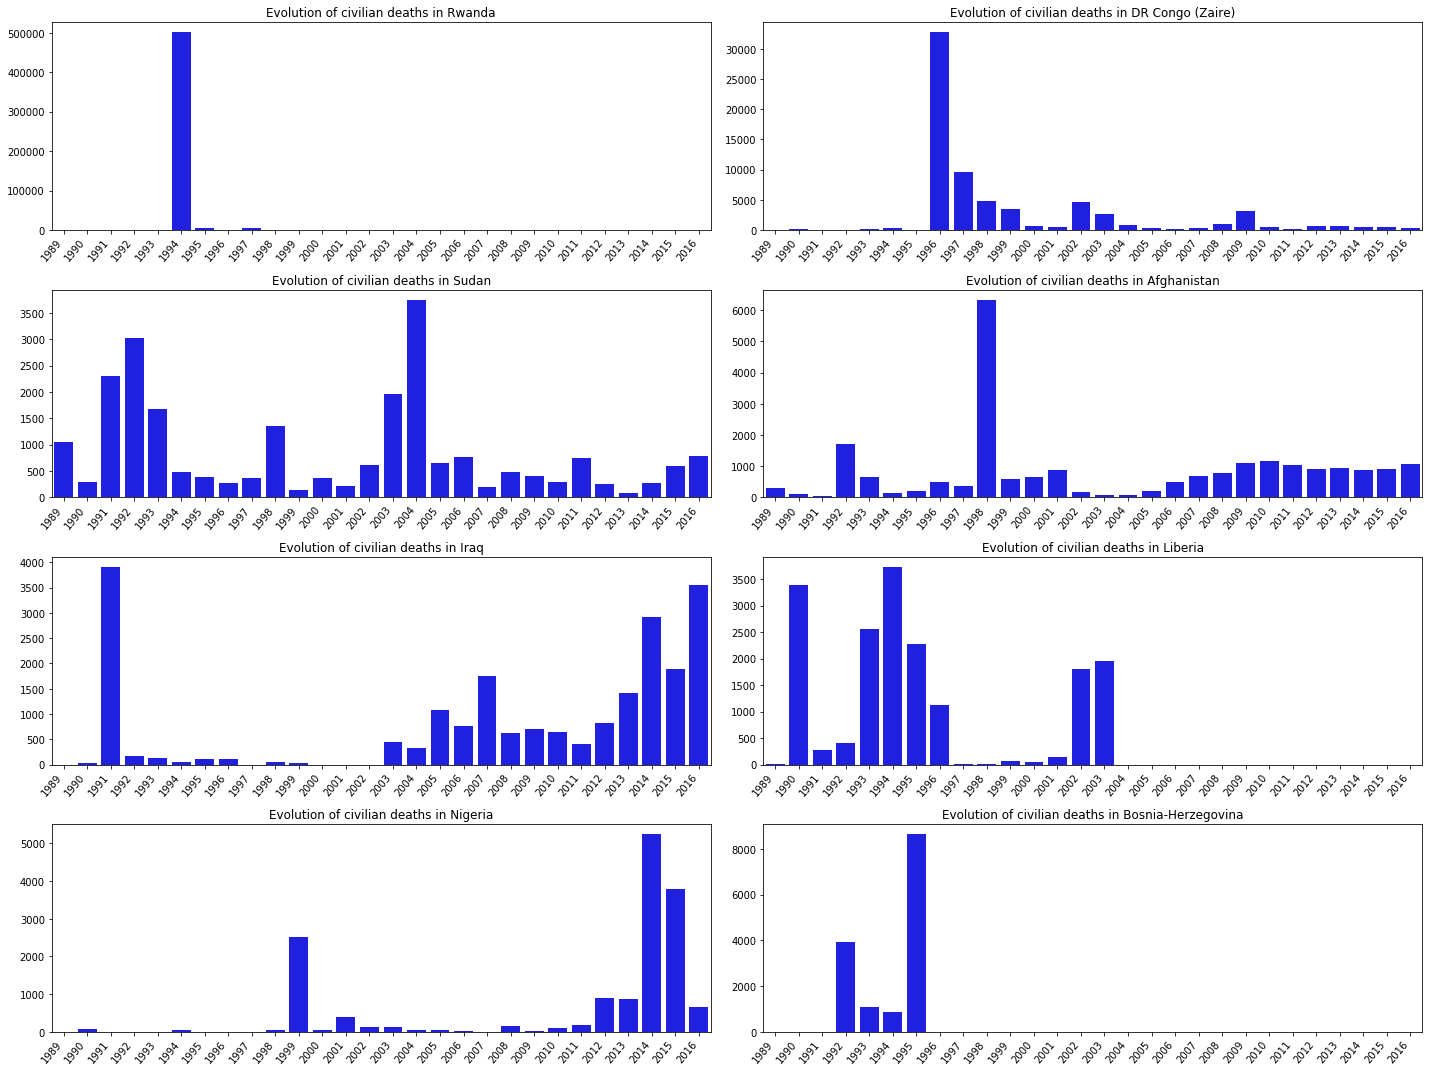

In [41]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
for i, name in enumerate(reversed(civilian_deaths.sum(axis=1).sort_values().index[-8:])):
    sns.barplot(x=civilian_deaths.columns, y=civilian_deaths.loc[name].values, ax=ax[i//2, i%2], color='blue')
    ax[i//2, i%2].set_xticklabels(civilian_deaths.columns, rotation=50, horizontalalignment='right')
    ax[i//2, i%2].set_title('Evolution of civilian deaths in {}'.format(name))
plt.tight_layout()
plt.show()

In [42]:
interact(build_map, df=fixed(insert_code(civilian_deaths, topo_data)), topo_data=fixed(topo_data), centro=fixed(centro), legend=fixed('civilian deaths'),
         year=widgets.IntSlider(min=1989, max=2016, step=1,value=1989))

interactive(children=(IntSlider(value=1989, description='year', max=2016, min=1989), Output()), _dom_classes=('widget-interact',))

<function plots.build_map>

The preceding cell will not render online (GitHub or NBViewer). The slider allows to choose the year we want to build the map of and then the map is build. Here is an example for year 2001.

In [43]:
build_map(year=2001, df=insert_code(civilian_deaths, topo_data), topo_data=topo_data, centro=centro, legend='Number of Civilian deaths for each country in 2001')

Note that these maps purely for exploratory purposes and more interactive and informative maps will be used in the data story.

### Number of events for each country

In [44]:
df['event'] = 1
tmp = pd.DataFrame(df.groupby(['country', 'year'])['event'].sum())
events_count = pd.DataFrame(index=countries, columns=df.drop_duplicates('year')['year'].sort_values().values)
events_count.fillna(value=0, inplace=True)

for i in tmp.index:
    events_count.loc[i[0], i[1]] = tmp.loc[i].values

In [45]:
interact(build_map, df=fixed(insert_code(events_count, topo_data)), topo_data=fixed(topo_data), centro=fixed(centro), legend=fixed('events'),
         year=widgets.IntSlider(min=1989, max=2016, step=1,value=1989))

interactive(children=(IntSlider(value=1989, description='year', max=2016, min=1989), Output()), _dom_classes=('widget-interact',))

<function plots.build_map>

The same for the previous cell, here is a example for year 1994.

In [46]:
build_map(year=1994, df=insert_code(events_count, topo_data), topo_data=topo_data, centro=centro, legend='Number of events for each country in 1994')

### Compare evolution of events type-wise (government or civil or terror)

In [47]:
df_type = pd.DataFrame(df.loc[df.type_of_violence == 1].groupby('year').sum().loc[:, 'event'])
df_type['type'] = 1
df_type.reset_index(inplace=True)
tmp = pd.DataFrame(df.loc[df.type_of_violence == 2].groupby('year').sum().loc[:, 'event'])
tmp['type'] = 2
tmp.reset_index(inplace=True)
df_type = df_type.append(tmp)
tmp = pd.DataFrame(df.loc[df.type_of_violence == 3].groupby('year').sum().loc[:, 'event'])
tmp['type'] = 3
tmp.reset_index(inplace=True)
df_type = df_type.append(tmp)
df_type.reset_index(inplace=True, drop=True)

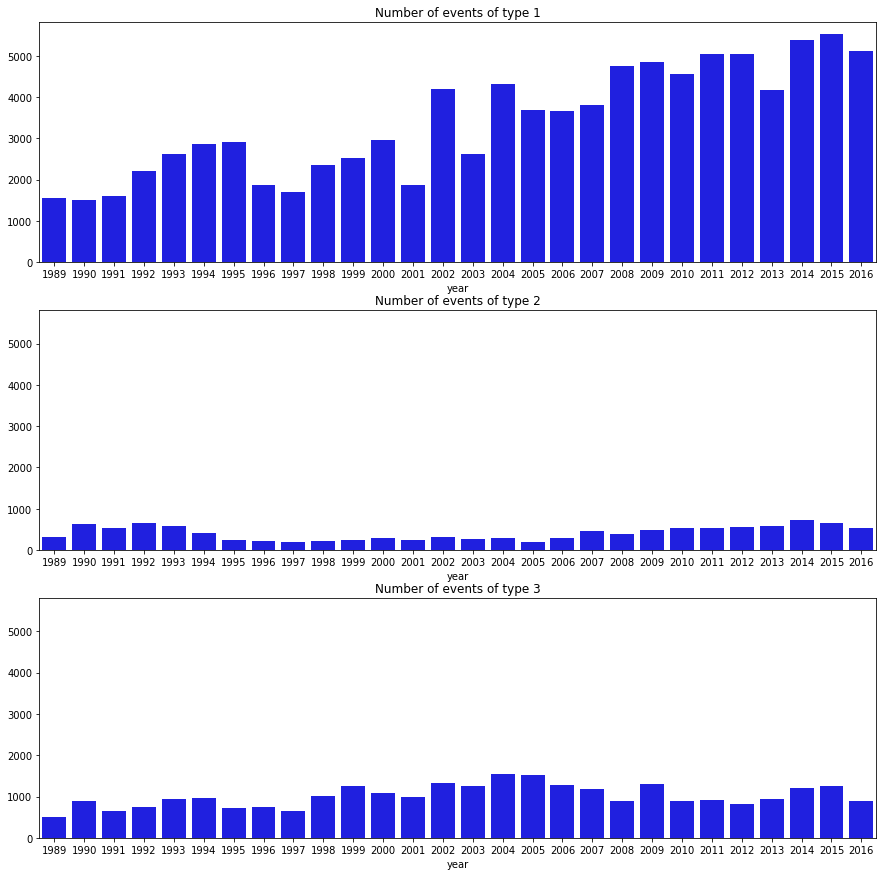

In [48]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15), sharey=True)
for i in range(3):
    sns.barplot(x = df.loc[df.type_of_violence == i+1].groupby('year').sum().loc[:, 'event'].index,
                y = df.loc[df.type_of_violence == i+1].groupby('year').sum().loc[:, 'event'].values, 
                ax=ax[i], color='blue')
    ax[i].set_title('Number of events of type {}'.format(i+1))
plt.show()

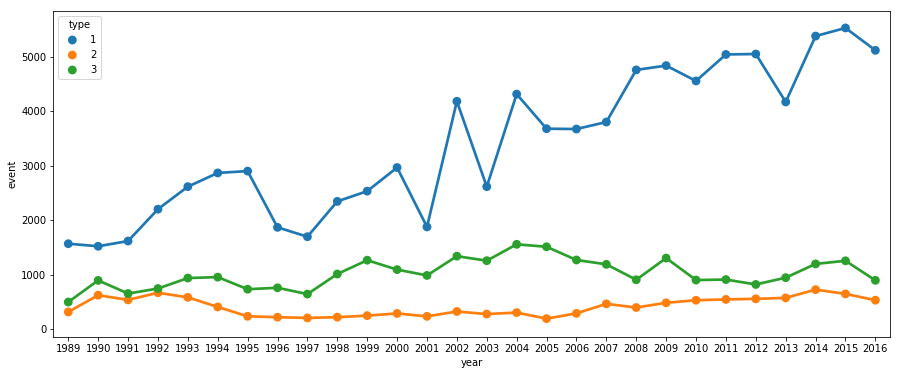

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.pointplot(data=df_type, x='year', y='event', hue='type', ax=ax)
plt.show()

Type 1 (government) violence seems to increase (actually the number of events increases), type 2 (civil) and 3 (terror) fluctuate but there is no real trend.

### Deaths per conflict

In [50]:
df.groupby('conflict_new_id').sum().columns

Index(['id', 'year', 'active_year', 'type_of_violence', 'dyad_new_id', 'gwnoa',
       'gwnob', 'number_of_sources', 'where_prec', 'latitude', 'longitude',
       'country_id', 'event_clarity', 'date_prec', 'deaths_a', 'deaths_b',
       'deaths_civilians', 'deaths_unknown', 'best', 'low', 'high', 'event'],
      dtype='object')

In [51]:
d = {}
tmp = df.groupby('conflict_new_id').sum()['best'].sort_values(ascending=False)

for i in tmp.index:
    d[list(df.loc[df.conflict_new_id == i, 'dyad_name'])[0]] = tmp[i]

total_death_per_conflict = pd.DataFrame(d, index=range(len(d))).loc[0].sort_values(ascending=False)

In [52]:
l = []
for i in tmp.index:
    l.append(df.loc[df.conflict_new_id == i, 'conflict_name'].drop_duplicates().values[0])

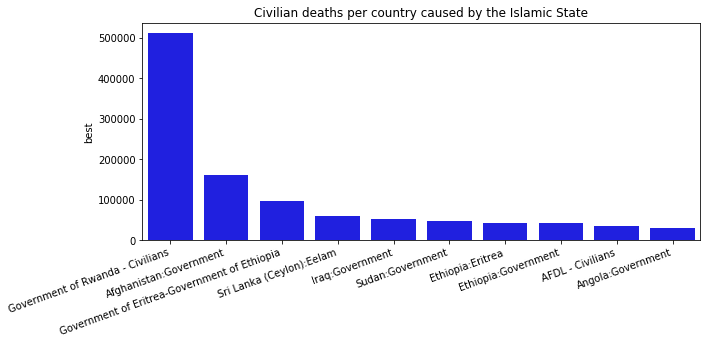

In [53]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=l[:10], y=tmp[:10], ax=ax, color='blue')
ax.set_xticklabels(l[:10], rotation=20, horizontalalignment='right')
ax.set_title('Civilian deaths per country caused by the Islamic State')
plt.show()

Let's look at a particular conflict: the Islamic State versus civilians.

In [54]:
tmp = pd.DataFrame(df.loc[df.dyad_name == 'IS - Civilians'].groupby('country').sum()['deaths_civilians'].sort_values(ascending=False))

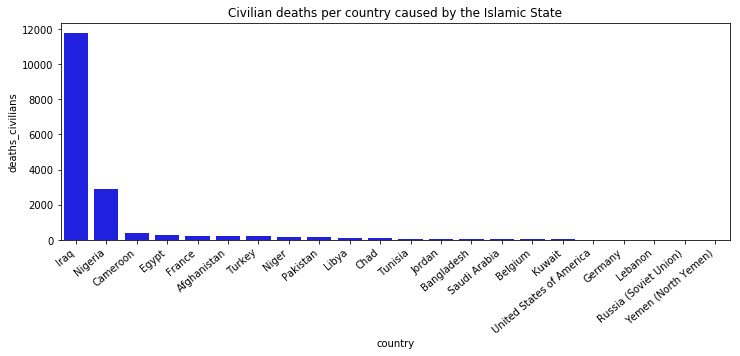

In [55]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=tmp.index, y=tmp.deaths_civilians, ax=ax, color='blue')
ax.set_xticklabels(tmp.index, rotation=40, horizontalalignment='right')
ax.set_title('Civilian deaths per country caused by the Islamic State')
plt.show()

This exploratory analysis gives us some insight on the data and shows us that it could be interesting to focus on some crisis the world have seen in order to put them in their context (link them with other crisis, locate them in space and time ...).

# 3. Research questions

Let's get back to the research questions asked in Milestone 1. Thanks to the previous analysis, we can already draw one conclusion : 
- The data set is incomplete when it comes to media coverage (question 3)

Reminder of the questions : 
    1. How has the world evolved in terms of conflicts after the cold war, i.e., during the time span covered in the dataset?
    2. Which countries have undergone the most important crises during these time spans and which of those crises might be interlinked spatially and politically?
    3. Does the coverage of conflicts by media represent the real-world numbers in terms of number of conflicts and fatalities, or is there a bias?
  


Let's start to find first replied to it. In this part, we might as well download and clean additional data sets when we find the need to enrich the original one.

## Question 1: How has the world evolved in terms of conflicts after the cold war, i.e., during the time span covered in the dataset?

This question is, in itself very vast and can be reformulated in several ways. 

First, the "post cold-war world" is generally defined as the world after 1991 with the collapse of the Soviet Union but the fall of the Berlin Wall in 1989 was already a striking sign of the end of the conflict. As the data set starts in 1989, we'll consider the period from 1989 to nowadays and call this the post col-war era. We want to show wether domestic peace in the affected countries has increased or decreased.

Second, the notion of peacefulness can be interpreted in different ways. The absence of fatalities is only one possible way of quantifying peace. This does not yet imply that no population groups are persecuted, systematically discriminated or excluded from society in some other way. According to the United Nations, ["peace means dignity, well-being for all, not just absence of war"](http://www.un.org/apps/news/story.asp?NewsID=48669#.Whmt4rQxGAw). Such measures are rather difficult to quantify from our dataset, but we can harness the following information:
- The number of people who died in a given country in a given year, and the part of civilians and other (unknown) population. Civilian deaths can be seen as a fair proxy for peace, since they are not actively involved in the war usually, therefore deaths of civilians due to conflicts is generally a very bad sign for peace.
- We can also look at the total number of fatalities, although seems to be a weaker metric than civilians, since the parties involved in the conflict can be held responsible. However, we might want to make a distinction by types of parties. For instance, government interventions could be seen as a measure to restore domestic safety (actions against rebellion, ensuring state sovereignty). Terrorism, on the other hand, seems like a very clear sign for the deterioration of the public safety. This distinction will be made in the data story visualization.
- Another possibility is to explicitly look at the international context of conflicts. For instance, if a country is surrounded by other countries in which there are conflicts too, the safety additionally decreases. Again, we will take this into account in the data story.
- Lastly, we might want to weigh fatalities by the total population of a country (in each year, if done rigorously), to assess the importance of the conflict relative to the total population. To do so, we have to find a dataset which contains decently accurate numbers of the total population of all countries worldwide which were involved in the conflicts, optimatlly for each year of the dataset. The [World Bank](https://data.worldbank.org/indicator/SP.POP.TOTL) provides such a dataset, which we will use in this report.
- In addition, we could enrich our dataset with data on Economic Wealth and correlate this data with conflicts in these countries. Again, such data is provided by the [World Bank](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD).

We start by performing a simple baseline assessment of died civilians in each year:

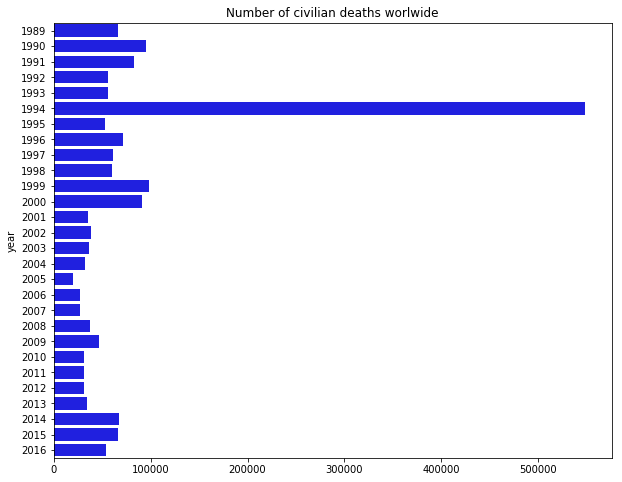

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(df.groupby('year').sum()['best'].values, df.groupby('year').sum()['best'].index, ax=ax, color='blue', orient = 'h')
ax.set_title('Number of civilian deaths worlwide')
plt.show()

The sharp rise in 1994 was caused by the Rwandan genocide that caused around 800.000 casualties according to the UN. This is to put in prospect of the 3 million deaths of WWII and 6 million deaths of the Shoah. This is huge taking into account the size of Rwanda for example.

#### Population Data

In [57]:
# load population data
df_pop = pd.read_csv('../data/pop_worldbank.csv')

# clean up data
df_pop = df_pop.drop(np.char.mod('%d', np.arange(1960,1989)),axis = 1)
df_pop = df_pop.drop(['2017','Unnamed: 62', 'Indicator Name', 'Indicator Code', 'Country Name'], axis = 1).set_index('Country Code')

# convert columns to int
df_pop = df_pop.fillna(0).astype(int)

# rename column
df_pop.index.rename('code',inplace=True)
df_pop.columns = np.char.mod('%d_pop', np.arange(1989,2017))
df_pop.head(2)

,1989_pop,1990_pop,1991_pop,1992_pop,1993_pop,1994_pop,1995_pop,1996_pop,1997_pop,1998_pop,...,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop
code,,,,,,,,,,,,,,,,,,,,,
ABW,61032,62149,64622,68235,72504,76700,80324,83200,85451,87277,...,101220,101353,101453,101669,102053,102577,103187,103795,104341,104822
AFG,11777609,12249114,12993657,13981231,15095099,16172719,17099541,17822884,18381605,18863999,...,26616792,27294031,28004331,28803167,29708599,30696958,31731688,32758020,33736494,34656032


There are a number of countries for which there is no match, maybe matching using the country codes works better. First, let's again take `tmp` DataFrame containing all fatalities and complete the missing country codes manually:

In [58]:
# tmp contains civilian deaths for all years
tmp = insert_code(civilian_deaths, topo_data)
# countries we match manually
tmp.loc[tmp.index == 'Bahrain', 'code'] = 'BHR'
tmp.loc[tmp.index == 'Comoros', 'code'] = 'COM'
tmp.loc[tmp.index == 'Guinea-Bissau', 'code'] = 'GNB'

In [59]:
for c in tmp.code:
    has_match = len(df_pop.loc[df_pop.index == c])
    foo = True
    if has_match == 0:
        foo = False

if foo: print('All countries are matched!')

All countries are matched!


Let's merge the dataframes of civilian deaths and national populations.

In [60]:
tmp.reset_index(inplace=True)
tmp.rename(columns = {'index':'Country Name'}, inplace = True)
df_merged = pd.DataFrame.merge(tmp,df_pop, left_on='code', right_on='code', right_index=True).set_index('code')
df_merged.head(2)

,Country Name,1989,1990,1991,1992,1993,1994,1995,1996,1997,...,2007_pop,2008_pop,2009_pop,2010_pop,2011_pop,2012_pop,2013_pop,2014_pop,2015_pop,2016_pop
code,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,303,101,49,1695,637,120,185,483,353,...,26616792,27294031,28004331,28803167,29708599,30696958,31731688,32758020,33736494,34656032
ALB,Albania,0,0,0,0,0,0,0,0,0,...,2970017,2947314,2927519,2913021,2905195,2900401,2895092,2889104,2880703,2876101


Let's compute for each year, what percentage of the population the number of civilian deaths represents. Of course, this is statistically a bit difficult to produce because we don't know whether the population censuses have been made at the beginning or at the end of the year. Given that most countries statistics are rather approximative in any case, and are most probably produced at different times of the year, we ignore the census month. Moreover, as we will see, the percentage of fatalities is in almost every case below 1 percent.

In [61]:
for year in np.arange(1989,2017):
    col = str(year)+'_pop'
    df_merged[str(year)+'_pct_died'] = (df_merged[year].values / (df_merged[str(year)+'_pop'].values+1e-5))*100
    df_merged[str(year)+'_pct_died'] = df_merged[str(year)+'_pct_died'].astype(float).round(2)

Let's visualize the result for 1994 for example (sorted by descending values).

In [62]:
year = 1994
df_merged.sort_values(by = str(year) + '_pct_died', ascending=False)[['Country Name', year, str(year) + '_pop', str(year) + '_pct_died']].head(10)

,Country Name,1994,1994_pop,1994_pct_died
code,,,,
RWA,Rwanda,501191,6005095,8.35
LBR,Liberia,3733,2012885,0.19
SLE,Sierra Leone,1551,4283621,0.04
BIH,Bosnia-Herzegovina,850,3948816,0.02
MLI,Mali,596,9353385,0.01
AFG,Afghanistan,120,16172719,0.00
PNG,Papua New Guinea,2,4770606,0.00
NGA,Nigeria,56,105355783,0.00
PAK,Pakistan,14,119769556,0.00


In Rwanda, in 1994, about 8% of the local popoulation died in 1994. This was caused by the genocide.

In [63]:
means_pct = []
for year in range(1989, 2017):
    means_pct.append(np.mean(df_merged[str(year)+'_pct_died'].values))

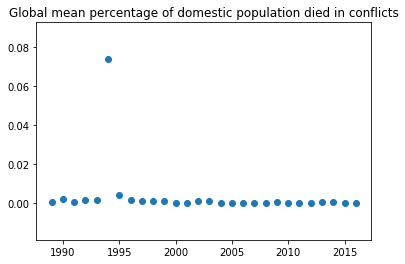

In [64]:
plt.scatter(np.arange(1989, 2017), means_pct)
plt.title("Global mean percentage of domestic population died in conflicts")
plt.show()

The problem with the figure above is that it dosn't really show the trend, because of the outlier in 1994 (Rwanda). Let's see what we get if we don't show 1994:

In [65]:
means_pct = np.asarray(means_pct)[means_pct!=np.max(means_pct)]
years = np.arange(1989, 2017)[np.arange(1989, 2017) !=1994]

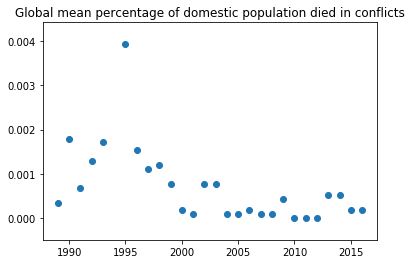

In [66]:
plt.scatter(years, means_pct)
plt.title("Global mean percentage of domestic population died in conflicts")
plt.ylim([np.min(means_pct)-.0005,np.max(means_pct)+.0005])
plt.show()

Indeed, this time we see that the average percentage of the population that died in a conflitct seemed rather to decrease in the second half of the dataset. However, this conclusion is only tentative, since the trend is not clear enough and the data series not long enough.

#### Economic data
To further assess the well-being of the population, we can have a look at the GDP for every country during this time, which is also provided by the [World Bank](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD). It seems particularly intersesting to study the correlation between wealth, and conflicts / war.

In [67]:
# load population data
df_gdp = pd.read_csv('../data/gdp_worldbank.csv')
# clean up data
df_gdp = df_gdp.drop(np.char.mod('%d', np.arange(1960,1989)),axis = 1)
df_gdp = df_gdp.drop(['2017','Unnamed: 62', 'Indicator Name', 'Indicator Code'], axis = 1).set_index('Country Name')

df_gdp[np.char.mod('%d', np.arange(1989,2017))] = df_gdp[np.char.mod('%d', np.arange(1989,2017))].round().fillna(0).astype(int)

In [68]:
# renaming the columns to prepare the merging.
df_gdp.columns = [str(col) + '_gdp' for col in df_gdp.columns]
df_gdp.rename(columns={'Country Code_gdp':'code'}, inplace=True) 
df_gdp.reset_index(inplace=True)

df_gdp.head(2)

,Country Name,code,1989_gdp,1990_gdp,1991_gdp,1992_gdp,1993_gdp,1994_gdp,1995_gdp,1996_gdp,...,2007_gdp,2008_gdp,2009_gdp,2010_gdp,2011_gdp,2012_gdp,2013_gdp,2014_gdp,2015_gdp,2016_gdp
0,Aruba,ABW,0,0,0,0,0,1330167598,1320670391,1379888268,...,2623726257,2791960894,2498932961,2467703911,2584463687,0,0,0,0,0
1,Afghanistan,AFG,0,0,0,0,0,0,0,0,...,9843842455,10190529882,12486943506,15936800636,17930239400,20536542737,20046334304,20050189882,19702986341,19469022208


For now, we just want to know whether there is a correlation between the economic activity (GDP) and conflicts. We assume that there could be an inverse correlation, as conflict generally stifles economic activity.

We would like to investigate this linkage between economic effects and conflicts in our data story.

## Question 2: Which countries have undergone the most important crises during these time spans and which of those crises might be interlinked spatially and politically?

For this question, we would like to first find out what the major crisis have been and then try to fit those crisis into categories. Let's see what we find out.

#### Visualization of the number of deaths (best estimation) for each year for each country:

In [69]:
year_country = df.groupby(['country', 'year'])['best'].sum()
tmp = pd.DataFrame(year_country)
total_deaths = pd.DataFrame(index=countries, columns=df.drop_duplicates('year')['year'].sort_values().values)
total_deaths.fillna(value=0, inplace=True)

for i in tmp.index:
    total_deaths.loc[i[0], i[1]] = tmp.loc[i].values

In [70]:
"""fig, ax = plt.subplots(nrows=len(countries)//2 + 1, ncols=2, figsize=(20,200))
for i, name in enumerate(countries):
    sns.barplot(x=total_deaths.columns, y=total_deaths.loc[name].values, ax=ax[i//2, i%2], color='blue')
    ax[i//2, i%2].set_xticklabels(total_deaths.columns, rotation=50, horizontalalignment='right')
    ax[i//2, i%2].set_title('Evolution of deaths in {}'.format(name))
plt.tight_layout()
plt.show()"""

"fig, ax = plt.subplots(nrows=len(countries)//2 + 1, ncols=2, figsize=(20,200))\nfor i, name in enumerate(countries):\n    sns.barplot(x=total_deaths.columns, y=total_deaths.loc[name].values, ax=ax[i//2, i%2], color='blue')\n    ax[i//2, i%2].set_xticklabels(total_deaths.columns, rotation=50, horizontalalignment='right')\n    ax[i//2, i%2].set_title('Evolution of deaths in {}'.format(name))\nplt.tight_layout()\nplt.show()"

These plots might give some insight. Let's refine the study.

**NB** This plots have been commented for the submission because even if they give some insight on the data, they break the read flow of the notebook. However, here is an example of such a plot:

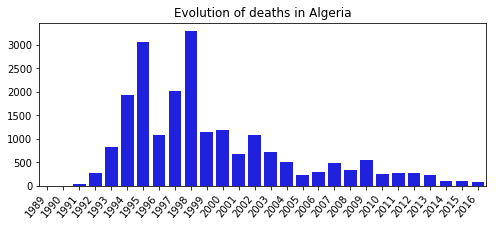

In [71]:
fig, ax = plt.subplots(figsize=(8,3))
sns.barplot(x=total_deaths.columns, y=total_deaths.loc['Algeria'].values, ax=ax, color='blue')
ax.set_xticklabels(total_deaths.columns, rotation=50, horizontalalignment='right')
ax.set_title('Evolution of deaths in Algeria')
plt.show()

#### Countries that underwent a crisis.

To find such countrie, first compute the median of the number of casualties per year for all countries. Then we select the countries that have a maximum number of deaths above 1000 times the median (+1 to include the countries where the median is 0).

In [80]:
medians = civilian_deaths.median(axis=1)
c = []
for i in civilian_deaths.index:
    tmp = civilian_deaths.loc[i]
    if np.amax(tmp.values) > 1000*(medians[i]+1):
        c.append(i)

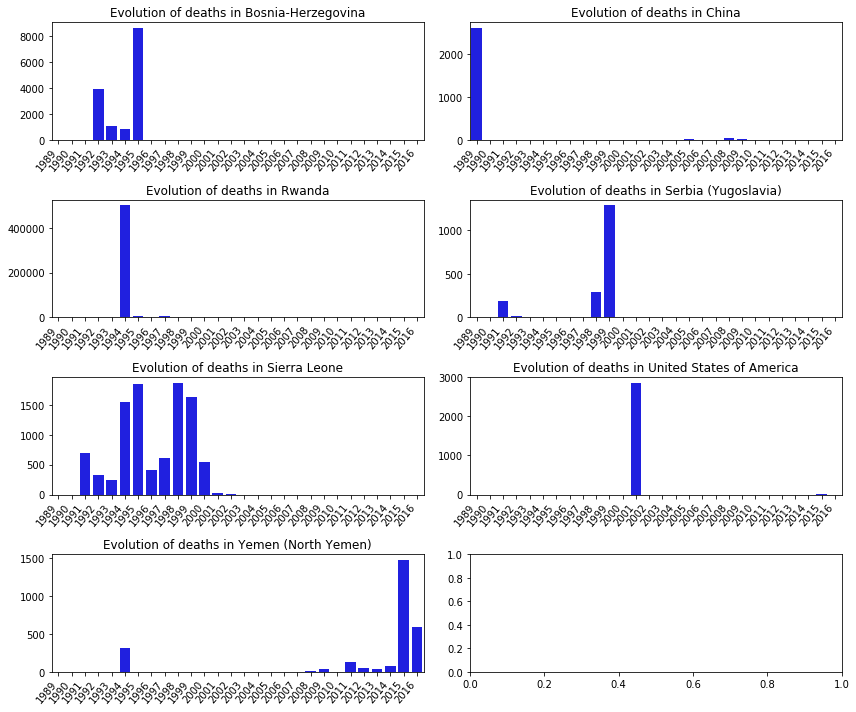

In [81]:
fig, ax = plt.subplots(nrows=len(c)//2 + 1, ncols=2, figsize=(12,10))
for i, name in enumerate(c):
    sns.barplot(x=civilian_deaths.columns, y=civilian_deaths.loc[name].values, ax=ax[i//2, i%2], color='blue')
    ax[i//2, i%2].set_xticklabels(civilian_deaths.columns, rotation=50, horizontalalignment='right')
    ax[i//2, i%2].set_title('Evolution of deaths in {}'.format(name))
plt.tight_layout()
plt.show()

For those countries, we know what crisis occured:

Country |Crisis
----||---|   
Bosnia Herzegovina |Bosnian war (92 95)
  China | Tiananmen Square protests (1989)
  Rwanda | Rwandan genocide of the Tutsi (1994)
  Serbia (Yugoslavia) | Yugoslav Wars (1991 1995)
  Sierra Leone | Sierra Leone Civil War (1991 2002)
  United States of America | 9/11 terrorist attacks
  Yemen (North Yemen) | Yemeni Civil War (1994), Yemeni Revolution (2011, 2012)

It has been quite easy to recover those crisis. In order to find the name of the crisis and the historical background of it, we had to use other sources of information. This might point to the need to enrich the data set.

One way to do so can be to classify the actors involved in crisis. This would allow us to identify the different sources of tensions in the world.

## Classifying the actors

In [74]:
governments = {}
cartels = {}
other = {}
christians = {}
muslims = {}
factions = {}  # those are separatist or people trying to do a coup
clans = {}     # those are clans such as in Somalia 
civilians = {}


for k in actors.keys():
    if 'Government' in actors[k][0] or 'Republic' in actors[k][0]:
        governments[k] = actors[k]
        continue
    if 'Cartel' in actors[k][0]:
        cartels[k] = actors[k]
        continue
    if 'Christian' in actors[k][0]:
        christians[k] = actors[k]
        continue
    if 'Muslims' in actors[k][0]:
        muslims[k] = actors[k]
        continue
    if 'faction' in actors[k][0]:
        factions[k] = actors[k]
        continue
    if 'Civilians' in actors[k][0]:
        civilians[k] = actors[k]
        continue
    if 'Isaaq' in actors[k][0] or 'Hawiye' in actors[k][0]:
        clans[k] = actors[k]
        continue
    other[k] = actors[k]

In [75]:
actors_names = ['governments', 'cartels', 'christians', 'muslims', 'factions', 'clans', 'civilians', 'other']
actors_cnts = [governments, cartels, christians, muslims, factions, clans, civilians, other]
actors_cnts = [len(a) for a in actors_cnts]

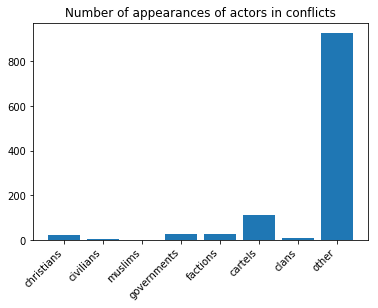

In [76]:
plt.bar(actors_names, actors_cnts)
plt.xticks(actors_names, rotation=45, horizontalalignment='right')
plt.title('Number of appearances of actors in conflicts')
plt.show()

This part will need further work but can bring a lot of value to the data. Some categories we can consider are: 
- socialists
- rebels 
- separatists 
- muslims 
- christians 
- minorities 
- islamists 
- sunnis 
- shias

Being able to do this classification would allow us to get a deep understanding of the world geopolitics and would give us a powerful tool for visualization. This would also give us an angle to tell our story, considering various type of conflicts one after the other.

We are currently looking for a data set containing this information. It could be done by scrapping the source articles but a rapid look at the data tells us it is not sufficient. It could also be done by scraping Wikipedia pages of the actors but this seems complicated as the names of the actors are not clean (for example `MCC` is an actor and a wikipedia resquest returns the page of the Maoist Communist Centre as well as many other pages such as the Maritime Christian College).

#### The Issue of water
It has been said that if the wars of the twentieth century were fought about oil, the one of the twenty-first will be fought about water (Ismail Serageldin). We would like to be able to add a vizualisation of events along with data on drought. There are many data sets about drought on the internet like the one provided by the [SPEI Global Drought Monitor](http://spei.csic.es/map/maps.html#months=1#month=9#year=2017). It is possible to visualize those using javascript then.

## 3. Does the coverage of crises by media represent the real-world numbers in terms of number of conflicts and fatalities, or is there a bias?

In the first part of this milestone, we noted that it seems difficult to judge the media coverrage of an event only using this data set as it aim is not to record all the media coverage of all events but only all events that some media have covered.

Let's try anyway to see if it is easy to get a list of what media covered each event for example. That could give us an indicator of media coverage. This indicator might be biased and inconsistent for the reasons we just recalled but that's an indicator anyway.

In [77]:
l = np.random.randint(low=0, high=len(df), size=10)
for i in l:
    print(df.loc[i, 'source_article'])
    print('')

Xinhua 2003-11-08, Over 40 people killed by rebels in Uganda's northern district

Reuters 8/3

Reuters 2012-12-05 "Sudan's army says clashes with Darfur rebels, kills three

Reuters, 1996-10-16, "Five dead in Egypt as police, militants clash.

INSEC "Human Rights Yearbook 2003

INSEC database

"Reuters News,2016-09-02,Turkey kills 27 Kurdish PKK militants in air, land strikes - military";"Reuters News,2016-09-02,Turkey kills 27 Kurdish militants as southeast violence escalates: military";"Agence France Presse,2016-09-03,Fourteen killed in attack, clashes with Kurdish rebels in Turkey"

EFE 12 June 2001 "COLOMBIA-COMBAT TEN FARC REBELS KILLED IN CLASHES WITH PARAMILITARIES" /R 12 June 2001 "UPDATE 1-Clashes in Colombian coca-growing jungle kill 10.

Voice of the Islamic Republic of Iran, Tehran, in Persian 1930 gmt 12 Jun 94

"Pajhwok News,2016-10-08,60 border police personnel surrender to Taliban in Badghis"



This seems difficult to parse the name of the source in an automatic maner. This field is not formated in a unique manner (it is done using either `:`, `,` or ` `).

Given the difficulty it represents and the low value such a study would bring, we have decided to leave this part aside for the time being. We'll get back to this if we have time and if we realize it is of great importance.

# Details of the data story and update on original aims.

## How has peace been doing since the fall of the Berlin Wall ? 
##### *A walkthrough of the geopolitics of the last thirty years.*

We would like to tell the story of the geopolitics of the last \~thirty years by looking at the results of major crisis but also to countries that have undergone general instability in this period without real outburst of violence. The aim is to understand past political crises and provide tools to understand and predict the current and future political state of the world.

The roadmap is the following:
 - Start with some genral statistic about world safety (as in part 2)
 - Detail some well known crisis such as the Rwandan genocide and compare them to some others (WWII, Shoah)
 - Explore events in a groups (socialists uprisals, ethnic conflicts, cartel wars)
 - Put those in relations with other data (economy, drought)
 
The story will be told on an interractive map relying on JavaScript libraries such as D3.
 

The research questions posed above will be broadened as follows:
 - We first need to analyze the world situation in terms of conflicts and domestic security by looking at the percentage of the population that has died in conflicts (i.e., for each year, quantifying the relative importance of conflicts with respect to the total population). We also want to enlarge upon the question of peace and domestic safety by taking into account other factors such as economic indicators or drought and try to find correlation with the conflicts.
 
 - To show the major changes, we would like to focus on a few key countries that have been involved in conflicts during several years, and show their interactions with other countries by only plotting the data only for these countries and if possible show interlinkages between several countries by means of fluxes.

 - We want to highlight the conflicts that have seen particularly high media coverage with respect to the number (or percentage, to be discussed) of people having died in these conflicts. We want to highlight these "overrepresentations" and "underrepresentations" by plotting a world map with a clear color scheme and possible oversized or undersized country surfaces. 